In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel("./dataset.xlsx")

# Initial Observations and Data Cleanup

In [3]:
df.columns = [
    "satisfaction_level",
    "last_evaluation",
    "number_project",
    "average_montly_hours",
    "time_spend_company",
    "work_accident",
    "left",
    "promotion_last_5years",
    "department", # "sales"
    "salary",
]
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

- Make column name casing consistent
- `department` column was mislabeled as `sales`

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [5]:
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

- No null data to handle
- `department` and `salary` are the only non-numerical columns and will need to be encoded

In [6]:
print(df['department'].value_counts())
print(df['salary'].value_counts())

department
sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: count, dtype: int64
salary
low       7316
medium    6446
high      1237
Name: count, dtype: int64


# EDA

In [7]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [8]:
df['salary'].value_counts()
# df.columns

salary
low       7316
medium    6446
high      1237
Name: count, dtype: int64

- Low and Medium salary ranges make up the bulk of employee datapoints
- We may need to account for this to properly train a model if there are not enough High range datapoints

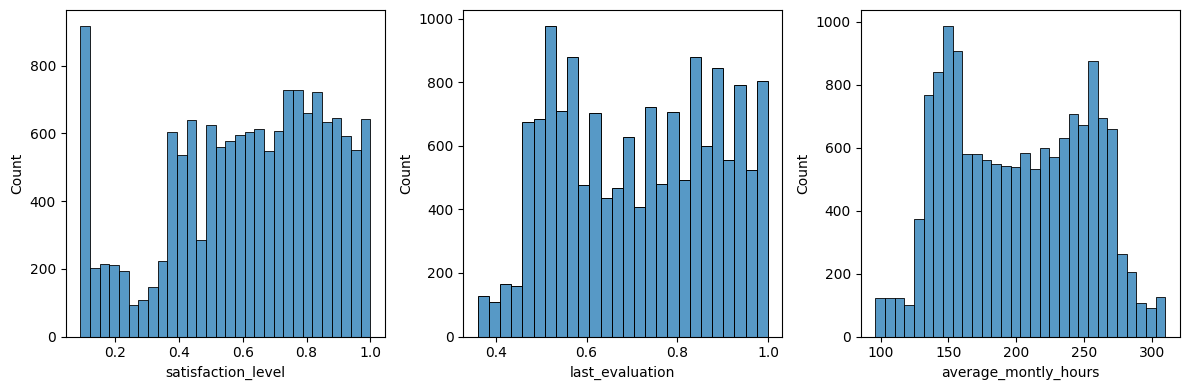

In [9]:
# sns.scatterplot(df, x='time_spend_company', y='satisfaction_level', hue="salary")
# sns.catplot(df, x="time_spend_company", y='satisfaction_level', hue="salary")
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
sns.histplot(df['satisfaction_level'], ax=axes[0])
sns.histplot(df['last_evaluation'], ax=axes[1])
sns.histplot(df['average_montly_hours'], ax=axes[2])
plt.tight_layout(h_pad=2,w_pad=1)

- `satisfaction_level` is negatively skewed and needs further investigation to help identify factors relating to low employee satisfaction
- `last_evaluation` is slightly positively skewed. Having more better performing employees is a good thing.
- `average_monthly_hours` has a fairly normal distribution, with the bulk of employees ranging from 140 - 260 hours per month (7-11 hours per working day). Further investigation should be conducted to see the relationship, if any, between `average_monthly_hours` and `satisfaction_level`

### Satisfaction Level

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'IT'),
  Text(1, 0, 'RandD'),
  Text(2, 0, 'accounting'),
  Text(3, 0, 'hr'),
  Text(4, 0, 'management'),
  Text(5, 0, 'marketing'),
  Text(6, 0, 'product_mng'),
  Text(7, 0, 'sales'),
  Text(8, 0, 'support'),
  Text(9, 0, 'technical')])

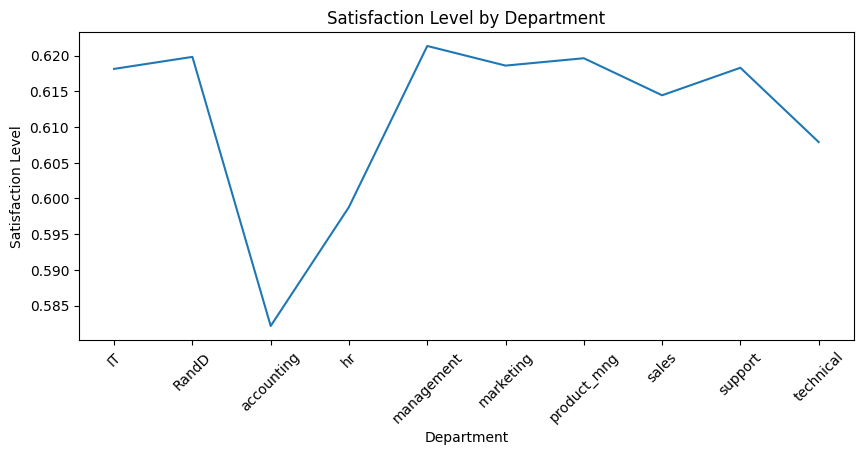

In [10]:
plt.figure(figsize=(10, 4))
sns.lineplot(df.groupby("department")["satisfaction_level"].mean())
plt.title("Satisfaction Level by Department")
plt.xlabel("Department")
plt.ylabel("Satisfaction Level")
plt.xticks(rotation=45)

Accounting has, by far, the lowest satisfaction level among departments, followed by Technical

<Axes: xlabel='department,left'>

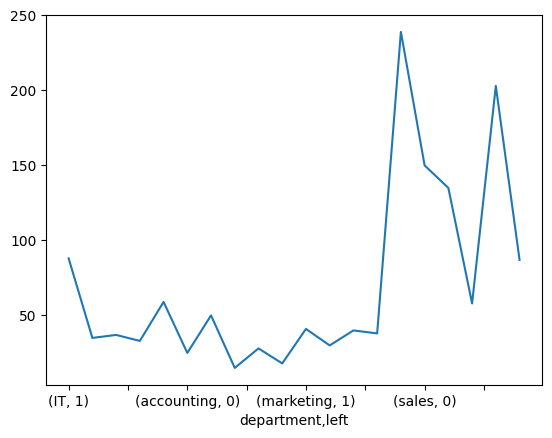

In [63]:
low_satisfaction_mask = df['satisfaction_level'] < 0.2
# df[low_satisfaction_mask].groupby('department')['left'].value_counts().plot()

### Correlation

<Axes: >

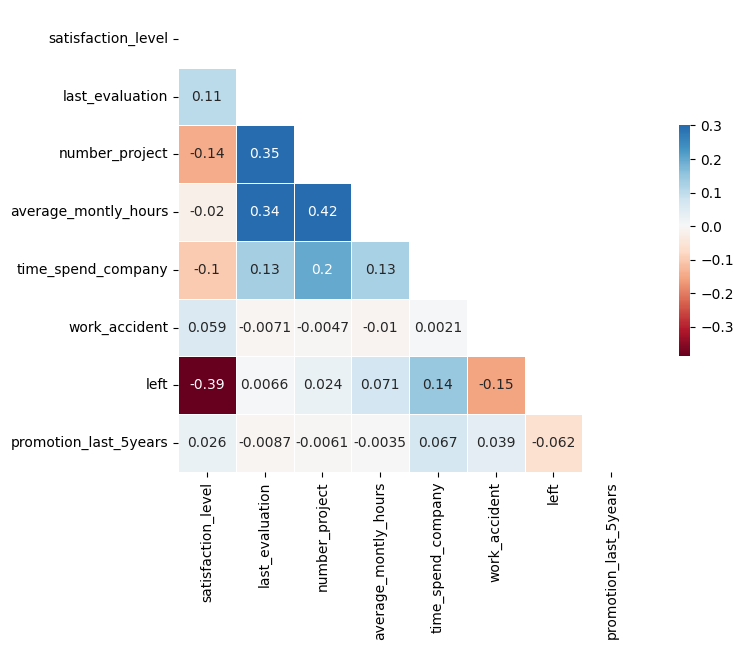

In [11]:
corr = df.corr(numeric_only=True)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap="RdBu",
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
)

- There is a relatively strong positive correlation between employees' last evaluation and the average monthly hours and number of projects, suggesting that employees who worked more hours and on more projects scored higher on their last evaluation
- Unsurprisingly, there is a relatively strong negative correlation between satisfaction level and the employee leaving the company
- There is a moderately strong positive correlation between last evaluation and satisfaction level, suggesting that employees who were evaluated more positively also have a higher level of satisfaction
- There is a moderately strong negative correclation between time spent at the company and number of projects worked on and employee satisfaction

### Left/Stayed

[Text(0, 0, 'Stayed'), Text(0, 1, 'Left')]

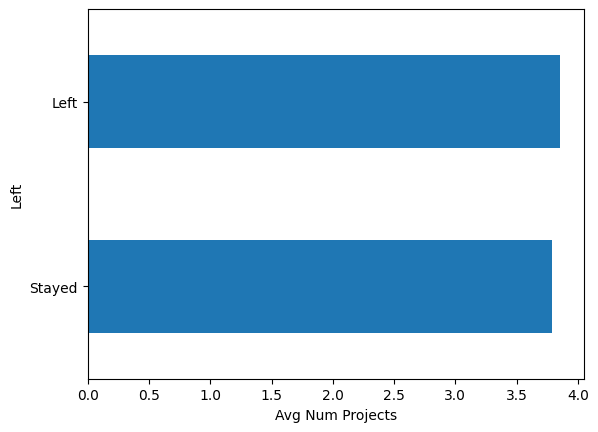

In [35]:
fig = df.groupby('left')['number_project'].mean().plot(kind='barh')
fig.set_xlabel('Avg Num Projects')
fig.set_ylabel('Left')
fig.set_yticklabels(['Stayed', 'Left'])

Employees who remained at the company worked on slightly fewer projects on average than those who left

### Other

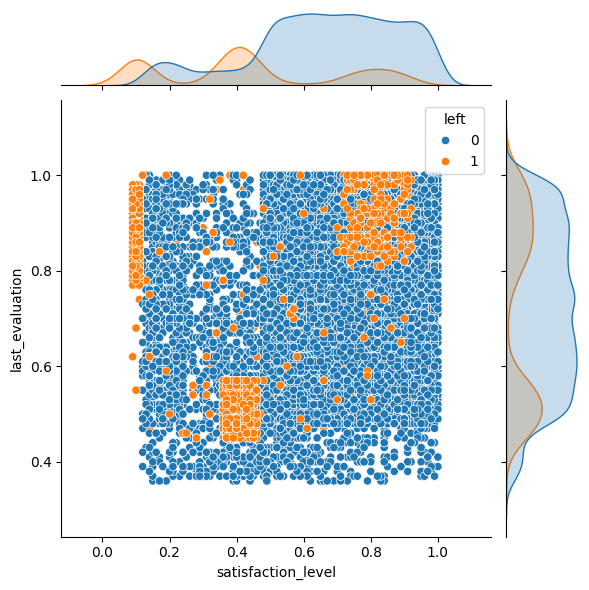

In [29]:
# plt.figure(figsize=(15, 10))
sns.jointplot(x='satisfaction_level', y='last_evaluation', data=df, hue='left')

# Clustering

# SMOTE

# Train and Cross-Validate Model(s)

# The Best Model

### AUC/ROC Curve

In [43]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

In [46]:
bc = load_breast_cancer()

In [47]:
X = bc.data
y = bc.target

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [52]:
 # adjust hyperparameters for penalty to apply regularization (overfitting)
LR = LogisticRegression()
LR.fit(X_train, y_train)

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [53]:
y_test_pred = LR.predict(X_test)

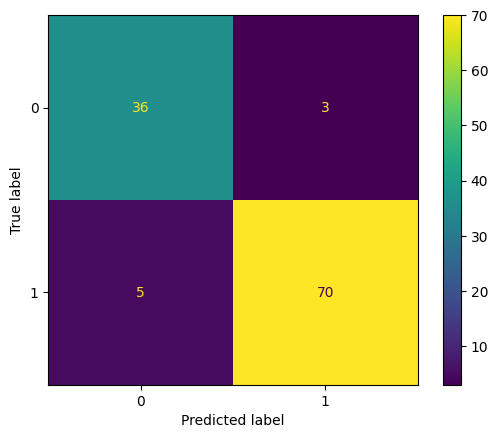

In [56]:
CM = confusion_matrix(y_test, y_test_pred)
CM_plot = ConfusionMatrixDisplay(CM)
CM_plot.plot()

In [60]:
# Get the probabilities
prob_score = LR.predict_proba(X_test)

# Get the positive
prob_pos = prob_score[:, 1]

# Compute ROC curve and AUC (area under curve)
# FPR (false positive rate)
# TPR (true positive rate)
FPR, TPR, Threshold = roc_curve(y_test, prob_pos)

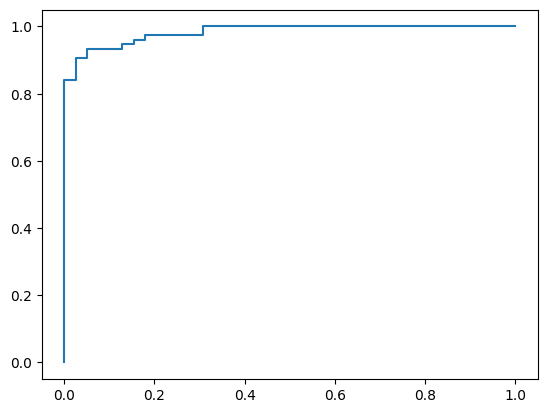

In [61]:
plt.plot(FPR, TPR)

# Prediction and Retention Strategies